#  Make figures and tables

## Imports and configuration

In [1]:
import os
import numpy as np
import pickle
import pyarrow.parquet as pq
from matplotlib import font_manager
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import jax
import jax.numpy as jnp
import equinox as eqx
import jax.random as jr
import pandas as pd
from scipy import stats
import PIL
import IPython
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle

import rvsr
from paths_config import paths_config
from train_utils import get_test_loss_steps, get_train_loss_steps, preprocess_batch_for_superresolution_task
from job import presets, hpars, get_preset_hpars
from eval_mse import get_mask_sums
from scipy.linalg import solve_toeplitz
from data_utils import np_linear_to_srgb
from padding import Padding2dLayer

font_files = font_manager.findSystemFonts(fontpaths=None, fontext="ttf") 
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["mathtext.fontset"] = "cm"

MONOSPACE_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

preset_ids = sorted(presets.keys())
num_seeds = 12
oc_list = [0, 1, 5]

def train_attempted(preset, seed):
    if preset in ['extr1', 'extr2', 'lp6x7'] and seed > 2:
        return False
    else:
        return True
    
os.makedirs(paths_config["graphs_folder"], exist_ok=True)

# Extrapolation error

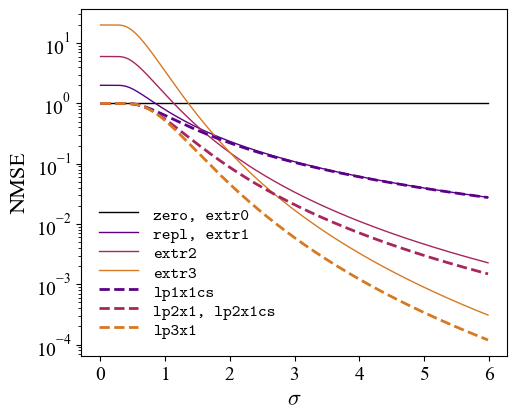

In [2]:
cmap = [
    "black",
    "#5b0188",
    "#a6265e",
    "#d67922",
]

blur_padding_methods = {
    "zero, extr0": [cmap[0], '-'],
    "repl, extr1": [cmap[1], '-'],
    "extr2": [cmap[2], '-'],
    "extr3": [cmap[3], '-'],
    "lp1x1cs": [cmap[1], '--'],
    "lp2x1, lp2x1cs": [cmap[2], '--'],
    "lp3x1": [cmap[3], '--'],
}

fixed_a = {
    "zero, extr0": [-1],
    "repl, extr1": [-1, 1],
    "extr2": [-1, 2, -1],
    "extr3": [-1, 3, -3, 1]
}

def kappa(d, sigma):
    return np.exp(-d**2/(2*sigma**2))

def get_a(method, sigma):
    k0 = kappa(0, sigma)
    k1 = kappa(1, sigma)
    k2 = kappa(2, sigma)
    k3 = kappa(3, sigma)
    if method in fixed_a:
        return np.array(fixed_a[method])
    else:
        if method == "lp1x1cs":
            return np.array([-1, k1/k0])
            # return np.concatenate(([-1], solve_toeplitz([k0], [k1]), [0, 0]))
        elif method == "lp2x1, lp2x1cs":
            return np.array([-1, (k1*k0 - k2*k1)/(k0**2 - k1**2), (k2*k0 - k1*k1)/(k0**2 - k1**2)])
            # return np.concatenate(([-1], solve_toeplitz([k0, k1], [k1, k2]), [0]))
        elif method == "lp3x1":
            return np.concatenate(([-1], solve_toeplitz([k0, k1, k2], [k1, k2, k3])))
        else:
            raise Exception(f"Unknown padding method {method}")

def blur_padding_error_var(a, sigma):
    i, j = np.meshgrid(np.arange(len(a)), np.arange(len(a)))
    return np.sum(a[i] * a[j] * kappa(j - i, sigma))

d = np.arange(-10, 10, 0.01)
sigma = np.arange(0.001, 6, 0.01)

plt.figure(figsize=(5.5, 4.5))
for method, (color, linestyle) in blur_padding_methods.items():
    plt.semilogy(
        sigma,
        [blur_padding_error_var(get_a(method, sigma), sigma) for sigma in sigma],
        linestyle,
        label=method,
        color=color,
        linewidth=1 if linestyle == "-" else 2
    )
#plt.xscale("log")
#plt.xlim(0.4, 15)
legend = plt.legend(labelspacing=0.08, framealpha=0)
plt.setp(legend.get_texts(), font="cmtt10", size=MONOSPACE_SIZE)
#plt.ylabel(r"$\text{Var}(\varepsilon)$")
plt.ylabel("NMSE")
plt.xlabel(r"$\sigma$")
plt.savefig(os.path.join(paths_config["graphs_folder"], "fig_data_blur.pdf"), pad_inches=0, bbox_inches="tight")

## Load loss histories and trained models
Sometimes loss histories have gaps. This is likely due to interruption during training, taking place between checkpointing and loss history recording. Model quality is not affected. Small gaps are fixed by linear interpolation. In case of large gaps, the loss history is discarded.

In [6]:
# Init related results
if "results" not in locals():
    results = {}
results["train_loss_histories"] = {}
results["test_loss_histories"] = {}
results["trained_models"] = {}
results["train_loss_steps"] = np.array(get_train_loss_steps(hpars))
results["test_loss_steps"] = np.array(get_test_loss_steps(hpars))

# Read loss histories
for preset in preset_ids:
    results["train_loss_histories"][preset] = np.full((num_seeds, len(results["train_loss_steps"])), fill_value=np.nan, dtype=np.float32)
    results["test_loss_histories"][preset] = np.full((num_seeds, len(results["test_loss_steps"])), fill_value=np.nan, dtype=np.float32)
    results["trained_models"][preset] = []
    for seed in range(num_seeds):
        #print(f"Preset: {preset}, seed: {seed}")
        model_eqx_filename = os.path.join(paths_config["trained_models_folder"], f"{preset}_s{seed}.eqx")
        train_loss_filename = os.path.join(paths_config["trained_models_folder"], f"{preset}_s{seed}_train_loss.parquet")
        test_loss_filename = os.path.join(paths_config["trained_models_folder"], f"{preset}_s{seed}_test_loss.parquet")
        if os.path.isfile(train_loss_filename):
            train_loss_table = pq.read_table(train_loss_filename)
            if os.path.isfile(model_eqx_filename):
                train_loss_history = train_loss_table["train_loss"].to_numpy()
                train_loss_steps = train_loss_table["step"].to_numpy()
                if np.array_equal(train_loss_steps, results["train_loss_steps"]):
                    results["train_loss_histories"][preset][seed] = train_loss_history
                else:
                    max_gap = np.max(train_loss_steps[1:] - train_loss_steps[:-1])
                    step_ratio = max_gap/np.max(results["train_loss_steps"][1:] - results["train_loss_steps"][:-1])
                    if step_ratio < 3:
                        #print(f"Small gaps in train loss history for run {preset}_s{seed}, max_gap={max_gap}, fixing using linear interpolation")
                        results["train_loss_histories"][preset][seed] = np.interp(results["train_loss_steps"], train_loss_steps, train_loss_history)
                    else:
                        print(f"Malformed train loss history for run {preset}_s{seed}, max_gap={max_gap}, discarding train loss history")
                        None
            else:
                #print(f"Failed run {preset}_s{seed} ending at step {train_loss_table["step"][-1]}, discarding train loss history")
                None
        else:
            #print("No train loss")
            None
        if os.path.isfile(test_loss_filename):
            test_loss_table = pq.read_table(test_loss_filename)
            if os.path.isfile(model_eqx_filename):
                test_loss_history = test_loss_table["test_loss"].to_numpy()
                test_loss_steps = test_loss_table["step"].to_numpy()
                if np.array_equal(test_loss_steps, results["test_loss_steps"]):
                    results["test_loss_histories"][preset][seed] = test_loss_history
                else:
                    max_gap = np.max(test_loss_steps[1:] - test_loss_steps[:-1])
                    step_ratio = max_gap/np.max(results["test_loss_steps"][1:] - results["test_loss_steps"][:-1])
                    if step_ratio < 3:
                        #print(f"Small gaps in test loss history for run {preset}_s{seed}, max_gap={max_gap}, fixing using linear interpolation")
                        results["test_loss_histories"][preset][seed] = np.interp(results["test_loss_steps"], test_loss_steps, test_loss_history)
                    else:
                        print(f"Malformed test loss history for run {preset}_s{seed}, max_gap={max_gap}, discarding test loss history")
                        None
            else:
                #print(f"Failed run {preset}_s{seed} ending at step {test_loss_table["step"][-1]}, discarding test loss history")
                None
        else:
            #print("No test loss")
            None
        if os.path.isfile(model_eqx_filename):
            print(f"Loading model {model_eqx_filename}")
            preset_hpars = get_preset_hpars(preset)
            model, model_state = eqx.nn.make_with_state(preset_hpars["model_type"])(sr_rate=preset_hpars["sr_rate"], **preset_hpars["model_hpars"], key = jr.PRNGKey(42))
            model_oc0, model_state_oc0 = eqx.nn.make_with_state(preset_hpars["model_type"])(sr_rate=preset_hpars["sr_rate"], **{**preset_hpars["model_hpars"], "output_crop":0}, key = jr.PRNGKey(42))
            model = rvsr.load_rvsr_weights(model, model_eqx_filename, model_oc0)
            results["trained_models"][preset].append({
                "model": model,
                "model_state": model_state
            })
        else:
            results["trained_models"][preset].append(None)

Loading model results/trained_models/extr1_s0.eqx
Loading model results/trained_models/extr1_s1.eqx
Loading model results/trained_models/extr1_s2.eqx
Loading model results/trained_models/extr2_s0.eqx
Loading model results/trained_models/extr2_s1.eqx
Malformed train loss history for run extr2_s2, max_gap=532361, discarding train loss history
Loading model results/trained_models/extr2_s2.eqx
Loading model results/trained_models/extr3_s0.eqx
Loading model results/trained_models/extr3_s1.eqx
Loading model results/trained_models/extr3_s2.eqx
Loading model results/trained_models/extr3_s3.eqx
Loading model results/trained_models/extr3_s4.eqx
Loading model results/trained_models/extr3_s5.eqx
Loading model results/trained_models/extr3_s6.eqx
Loading model results/trained_models/extr3_s7.eqx
Loading model results/trained_models/extr3_s8.eqx
Loading model results/trained_models/extr3_s9.eqx
Loading model results/trained_models/extr3_s10.eqx
Loading model results/trained_models/extr3_s11.eqx
Loadi

## Load evaluations of MSE, inference time, train time, layer NMSE

In [7]:
eval_results_filename = paths_config["eval_results_filename"]
with open(os.path.join(paths_config["results_folder"], eval_results_filename), "rb") as f:
    eval_results = pickle.load(f)

print(eval_results.keys())

if "results" not in locals():
    results = {}
results = {
    **results,
    **eval_results
}
del eval_results

dict_keys(['output_crop_sumsqs', 'largest_train_batch_sizes', 'train_step_times', 'largest_inference_batch_sizes', 'inference_step_times', 'padding_seed_layer_nmses'])


## Utility functions

In [4]:
def get_common_success_seeds(presets):
    table = []
    for preset in presets:
        table.append([False if model is None else True for model in results["trained_models"][preset]])
    return np.arange(num_seeds)[np.all(table, axis=0)]

def get_color_list():
    return ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'teal', 'gray', 'cyan', 'magenta', 'brown']

def get_shape_list():
    return ['o', '^', 's', 'd', 'p', 'h', '*', 'x', '+', 'v', '>', '<']

def get_1d_onion_bootstrap_abs(results, preset, valid_seeds, conf=0.95, resamples=10_000):
    def get_onion_loss(preset, seed, edge_dist):
        mask_sums = get_mask_sums(hpars)
        if edge_dist < 10:
            loss = (results["output_crop_sumsqs"][preset][seed][edge_dist]
                    -results["output_crop_sumsqs"][preset][seed][edge_dist+1])
            corr_fact = mask_sums[edge_dist]-mask_sums[edge_dist+1]
        elif edge_dist == 10:
            loss = results["output_crop_sumsqs"][preset][seed][edge_dist]
            corr_fact = mask_sums[edge_dist]
        return loss/corr_fact
    means_of_means = []
    ci_low, ci_high = [], []
    for edge_dist in range(11):
        loss_means = []
        for seed in valid_seeds:
            loss_means.append(np.mean(get_onion_loss(preset, seed, edge_dist)))
        result = stats.bootstrap(
            (np.array(loss_means),), np.mean, confidence_level=conf, n_resamples=resamples
        )
        means_of_means.append(np.mean(loss_means))
        low, high = result.confidence_interval
        ci_low.append(np.mean(loss_means) - low)
        ci_high.append(high - np.mean(loss_means))
    return means_of_means, ci_low, ci_high, len(valid_seeds)

## Save markers

In [5]:
for seed, (color, shape) in enumerate(zip(get_color_list(), get_shape_list())):
    markersize=np.sqrt(160.0)/2
    fig, ax = plt.subplots(figsize=(markersize/72*2, markersize/72*2))  # Small figure
    ax.plot(0, 0, marker=shape, color=color, alpha=0.4, markersize=markersize, markeredgewidth=0.5)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis("off")
    
    filename = os.path.join(paths_config["graphs_folder"], f"s{seed}.pdf")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    #plt.show()
    plt.close(fig)
    print(f"Saved: {filename}")

Saved: plots/s0.pdf
Saved: plots/s1.pdf
Saved: plots/s2.pdf
Saved: plots/s3.pdf
Saved: plots/s4.pdf
Saved: plots/s5.pdf
Saved: plots/s6.pdf
Saved: plots/s7.pdf
Saved: plots/s8.pdf
Saved: plots/s9.pdf
Saved: plots/s10.pdf
Saved: plots/s11.pdf


## Load test data and calculate test data RGB biases and mean variance

In [2]:
import data_utils
data_id = "test"  # "train" or "test" data
data_path = os.path.join(paths_config["dataset_folder"], paths_config["test_data_filename"])
data = data_utils.load_data_array(data_path, id=data_id)
print(np.mean(data, axis=(-1, -2, -4), keepdims=False))
print(np.mean((data - np.mean(data, axis=(-1, -2), keepdims=True))**2))

Loaded test data numpy array with shape (1000, 3, 512, 512) and dtype float32
[-0.28047428 -0.30902568 -0.22211602]
0.043799866


## Sample padding images

In [ ]:
paper_diffuse_reflectance = 0.8
input_size = (48, 48)
num_padding = ((24, 24), (24, 24))
images = []
example_indexes = [5, 1, 2, 3, 4, 0, 6, 7, 8, 9]  # Non-cherry-picked, just swapped 0 and 5 for better text visibility
batch = np.take(data, example_indexes, axis=0)
target = jax.jit(lambda batch : preprocess_batch_for_superresolution_task(batch, (input_size[0]+num_padding[0][0]+num_padding[0][1])*4, (input_size[1]+num_padding[1][0]+num_padding[1][1])*4, 4, False)[0])(batch)
images.append(np.hstack(np.moveaxis(np_linear_to_srgb((target*0.5+0.5)/paper_diffuse_reflectance), source=1, destination=3)))
input = target[:, :, num_padding[0][0]:-num_padding[0][1], num_padding[1][0]:-num_padding[1][1]]
padding_methods = ["Target"]
for preset in presets:
    if (not preset.endswith("_oc1")) and (not preset.endswith("_oc5")) and preset != "zero-zero" and preset != "extr1":
        padding_method = preset if preset != "zero-repl" else "zero"
        padding_methods.append(padding_method)
        preset_hpars = get_preset_hpars(preset)["model_hpars"]
        images.append(np.hstack(np.moveaxis(np_linear_to_srgb((jax.vmap(Padding2dLayer(num_padding, preset_hpars["conv_padding_method"], preset_hpars["padding_method_kwargs"]))(input)*0.5+0.5)/paper_diffuse_reflectance), source=1, destination=3)))
image = np.vstack(images)
image_width = 11
image_height = 11*image.shape[0]/image.shape[1]
row_height = image.shape[0]/len(padding_methods)
dpi = image.shape[1]/image_width
plt.figure(figsize=(image_width, image_height), dpi=dpi)
plt.imshow(image, interpolation="nearest")
plt.axis('off')
#for col in range(8):
#    plt.gca().add_patch(Rectangle((24.5 + col*48*2, 24.5), 48, 48, edgecolor = 'gray', fill=False, lw=0.125))
for row, padding_method in enumerate(padding_methods):
    plt.text(8, 8 + row*row_height, padding_method, horizontalalignment='left', verticalalignment='top', **{} if row == 0 else {"font":"cmtt10", "size":MONOSPACE_SIZE}, path_effects=[] if not padding_method.startswith("extr") else [pe.withStroke(linewidth=4, foreground="white", alpha=0.5), pe.withStroke(linewidth=3, foreground="white", alpha=0.5), pe.withStroke(linewidth=2, foreground="white", alpha=0.5)])
plt.gca().set_position((0, 0, 1, 1))
plt.savefig(os.path.join(paths_config["graphs_folder"], f"fig_padding_samples.pdf"), pad_inches=0, bbox_inches="tight")
#plt.savefig(os.path.join(f"fig_padding_samples.png"), pad_inches=0, bbox_inches="tight")
plt.show()

## Use models in tiled processing and show corner between processed tiles

In [ ]:
seed = 10  # This should be a seed which resulted in success for all presets
num_images = 8
zoomed_area_width = 192
paper_diffuse_reflectance = 0.8

def infer(model, state, inputs, key=None):
    predictions, state = jax.vmap(
        model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None)
    )(inputs, state, key)
    return predictions

example_indexes = [5, 1, 2, 3, 4, 0, 6, 7]  # Non-cherry-picked, just swapped 0 and 5 for better text visibility
batch = np.take(data, example_indexes, axis=0)
sr_rate = 4
window_size = (zoomed_area_width + 2*sr_rate, zoomed_area_width + 2*sr_rate)
shift_y = (batch.shape[-2]-window_size[0])//2
shift_x = (batch.shape[-1]-window_size[1])//2
inputs, targets = preprocess_batch_for_superresolution_task(
    batch[:, :, shift_y:shift_y+window_size[0], shift_x:shift_x+window_size[1]], zoomed_area_width, zoomed_area_width, sr_rate, False, None
)
safe_inputs, _ = preprocess_batch_for_superresolution_task(
    batch, batch.shape[-2]-sr_rate*2, batch.shape[-1]-sr_rate*2, sr_rate, False, None
)
inputs = jax.image.resize(inputs, targets.shape, "nearest")
inputs = np.moveaxis(np_linear_to_srgb((inputs*0.5+0.5)/paper_diffuse_reflectance), source=1, destination=3)
srgb_targets = np.moveaxis(np_linear_to_srgb((targets*0.5+0.5)/paper_diffuse_reflectance), source=1, destination=3)
image = np.vstack([np.hstack(inputs), np.hstack(srgb_targets)])
image_width = 11
image_height = 11*image.shape[0]/image.shape[1]
row_height = image.shape[0]/2
dpi = image.shape[1]/image_width
plt.figure(figsize=(image_width, image_height), dpi=dpi)
plt.imshow(image, interpolation="nearest")
plt.axis('off')
for row, text in enumerate(["Low-res input", "High-res target"]):
    plt.text(8, 8 + row*row_height, text, horizontalalignment='left', verticalalignment='top')
plt.gca().set_position((0, 0, 1, 1))
plt.savefig(os.path.join(paths_config["graphs_folder"], f"fig_inputs_targets.pdf"), pad_inches=0, bbox_inches="tight")
plt.show()

for output_crop in [0, 1, 5]:
    print(f"Output crop {output_crop}")
    padding_methods = []
    images = []
    errors = []
    for preset in list(presets.keys()):
        if preset in results["trained_models"] and results["trained_models"][preset][seed] is not None:
            hpars = get_preset_hpars(preset)
            if hpars["model_hpars"]["output_crop"] == output_crop:
                padding_methods.append(preset.split("_")[0])
                model = results["trained_models"][preset][seed]["model"]
                model_state = results["trained_models"][preset][seed]["model_state"]
                oc = hpars["model_hpars"]["output_crop"]*hpars["sr_rate"]
                window_size = (hpars["image_shape"][1] + 2*hpars["sr_rate"], hpars["image_shape"][2] + 2*hpars["sr_rate"])
                v_tiled = []
                for y, uncropped_shift_y in enumerate([(batch.shape[-2]-hpars["image_shape"][1]*2)//2, (batch.shape[-2]-hpars["image_shape"][1]*2)//2 + hpars["image_shape"][1]]):
                    shift_y = uncropped_shift_y - hpars["sr_rate"] + (oc if y == 0 else -oc)
                    h_tiled = []
                    for x, uncropped_shift_x in enumerate([(batch.shape[-1]-hpars["image_shape"][2]*2)//2, (batch.shape[-1]-hpars["image_shape"][2]*2)//2 + hpars["image_shape"][2]]):
                        shift_x = uncropped_shift_x - hpars["sr_rate"] + (oc if x == 0 else -oc)
                        inputs, _ = preprocess_batch_for_superresolution_task(
                            batch[:, :, shift_y:shift_y+window_size[0], shift_x:shift_x+window_size[1]], hpars["image_shape"][1], hpars["image_shape"][2], hpars["sr_rate"], False, None
                        )
                        predictions = infer(model, model_state, inputs)
                        h_tiled.append(predictions)
                    h_tiled = np.concatenate(h_tiled, axis=-1)
                    v_tiled.append(h_tiled)
                v_tiled = np.concatenate(v_tiled, axis=-2)
                cut = (v_tiled.shape[-1] - zoomed_area_width)//2
                tiled = v_tiled[..., cut:-cut, cut:-cut]
                safe_predictions = infer(model, model_state, safe_inputs)
                safe_cut = (safe_predictions.shape[-1] - zoomed_area_width)//2
                safe_predictions = safe_predictions[..., safe_cut:-safe_cut, safe_cut:-safe_cut]
                images.append(np.hstack(np.moveaxis(np_linear_to_srgb((tiled*0.5+0.5)/paper_diffuse_reflectance), source=1, destination=3)))
                deviation = np.abs(safe_predictions-tiled)
                print(np.max(deviation))
                errors.append(np.hstack(np.moveaxis(np_linear_to_srgb(4*deviation/paper_diffuse_reflectance), source=1, destination=3)))
    image = np.vstack(images)
    error = np.vstack(errors)
    image_width = 11
    image_height = 11*image.shape[0]/image.shape[1]
    row_height = image.shape[0]/len(padding_methods)
    dpi = image.shape[1]/image_width
    plt.figure(figsize=(image_width, image_height), dpi=dpi)
    plt.imshow(image, interpolation="nearest")
    plt.axis('off')
    #plt.text(image.shape[1]/2, -5, f"Output crop {output_crop}", horizontalalignment='center', verticalalignment='bottom')
    for row, padding_method in enumerate(padding_methods):
        plt.text(8, 8 + row*row_height, padding_method, horizontalalignment='left', verticalalignment='top', font="cmtt10", size=MONOSPACE_SIZE) # path_effects=[pe.withStroke(linewidth=4, foreground="white", alpha=0.5), pe.withStroke(linewidth=3, foreground="white", alpha=0.5), pe.withStroke(linewidth=2, foreground="white", alpha=0.5)], 
    plt.gca().set_position((0, 0, 1, 1))
    plt.savefig(os.path.join(paths_config["graphs_folder"], f"fig_stitched_output_crop_{output_crop}.pdf"), pad_inches=0, bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(image_width, image_height), dpi=dpi)
    plt.imshow(error, interpolation="nearest")
    plt.axis('off')
    #plt.text(image.shape[1]/2, -5, f"Output crop {output_crop}", horizontalalignment='center', verticalalignment='bottom')
    for row, padding_method in enumerate(padding_methods):
        plt.text(8, 8 + row*row_height, padding_method, horizontalalignment='left', verticalalignment='top', font="cmtt10", size=MONOSPACE_SIZE, color="white") # path_effects=[pe.withStroke(linewidth=4, foreground="white", alpha=0.5), pe.withStroke(linewidth=3, foreground="white", alpha=0.5), pe.withStroke(linewidth=2, foreground="white", alpha=0.5)], 
    plt.gca().set_position((0, 0, 1, 1))
    plt.savefig(os.path.join(paths_config["graphs_folder"], f"fig_shift_invariance_abs_deviation_output_crop_{output_crop}.pdf"), pad_inches=0, bbox_inches="tight")
    plt.show()
    #image = PIL.Image.fromarray(image)
    #IPython.display.display(image)
    #error_image = PIL.Image.fromarray(np.vstack(errors))
    #IPython.display.display(error_image)

## Layer NMSE scatterplot

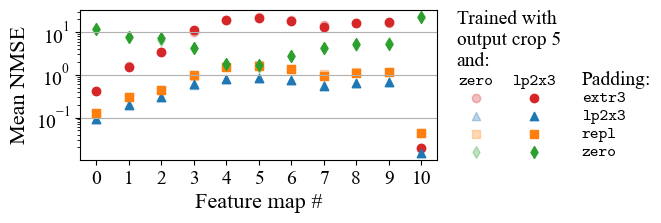

In [165]:
fig = plt.figure(figsize=(5.5, 2*0.75))

colors = {
    "lp2x3": "tab:blue",
    "repl": "tab:orange",
    "zero": "tab:green",
    "extr3": "tab:red"
}

legend_xs = [0.2, 0.5, 0.75]
legend_ys = [1, 0.5, 0.41, 0.29, 0.17, 0.05]

ax = fig.add_axes([0, 0, 0.65, 1])  # 75% of figure width
legend_axs = (fig.add_axes([0.65, 0, 0.35, 1]), fig.add_axes([0.65, 0, 0.35, 1]))
for train_preset_index, (train_preset, marker, alpha) in enumerate(zip(["zero_oc5", "lp2x3_oc5"], ['o', '^'], [0.3, 1])):
    legend_axs[train_preset_index].set_xlim((0, 1))
    legend_axs[train_preset_index].set_ylim((0, 1))
    legend_axs[train_preset_index].axis("off")
    legend_axs[train_preset_index].text(legend_xs[train_preset_index], legend_ys[1], train_preset.split("_")[0], horizontalalignment="center", verticalalignment="baseline", font="cmtt10", fontsize=MONOSPACE_SIZE)
    for preset_index, ((preset, seed_list), shape) in enumerate(zip(sorted(results["padding_seed_layer_nmses"][train_preset].items()), ['o', '^', 's', 'd'])):
        seed_mean = np.mean(np.array(seed_list), axis=0)
        ax.scatter(np.arange(11), seed_mean, label=preset if train_preset=="lp2x3_oc5" else None, marker=shape, color=colors[preset], alpha=alpha)
        legend_axs[train_preset_index].scatter([legend_xs[train_preset_index]], [legend_ys[preset_index + 2]], marker=shape, color=colors[preset], alpha=alpha)
        if train_preset_index == 0:
            legend_axs[train_preset_index].text(legend_xs[2], legend_ys[preset_index + 2], preset, horizontalalignment="left", verticalalignment="center", font="cmtt10", fontsize=MONOSPACE_SIZE)
    

#fig.setp(legend.get_texts(), font="cmtt10", size=MONOSPACE_SIZE)
ax.set_yscale("log")
ax.set_xlabel("Feature map #")
ax.set_ylabel("Mean NMSE")
ax.grid(which="major", axis="y")
ax.set_xticks(np.arange(11))

# Creating the legend on the right side
handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0, 1), framealpha=1, prop={"family": "cmtt10"}, fontsize=MONOSPACE_SIZE)
legend_axs[0].text(legend_xs[0]-0.1, legend_ys[0], "Trained with\noutput crop 5\nand:", horizontalalignment="left", verticalalignment="top")
legend_axs[0].text(legend_xs[-1], legend_ys[1], "Padding:", horizontalalignment="left", verticalalignment="baseline")

plt.savefig(os.path.join(paths_config["graphs_folder"], "fig_layer_nmse.pdf"), pad_inches=0, bbox_inches="tight")


## Presets and seeds table

In [ ]:
def get_mark(attempted, model):
    if not attempted:
        return r"\dmark"
    else:
        if model is not None:
            return r"\cmark"
        else:
            return r"\xmark"

def create_checkmark_table(results):
    preset_to_seed_tickmarks = {}
    for preset in presets:
        preset_to_seed_tickmarks[preset] = [get_mark(attempted, model) for (attempted, model) in zip([train_attempted(preset, seed) for seed in range(num_seeds)], results["trained_models"][preset])]

    header = [rf"\includegraphics{{markers/s{seed}.pdf}}" for seed in range(12)]
    df = pd.DataFrame.from_dict(preset_to_seed_tickmarks, orient='index')
    df.columns = header

    # create padding and loss columns out of preset string
    paddings, loss_crops = [], []
    for preset in presets:
        padding, loss_crop = (r"\texttt{" + preset.split("_")[0] + "}", get_preset_hpars(preset)["model_hpars"]["output_crop"])
        paddings.append(padding)
        loss_crops.append(loss_crop)

    df.insert(0, "padding method", paddings)
    df.insert(1, "output crop", loss_crops)

    #df = df.sort_values(by=['pad preset', 'loss crop']) 
        
    latex_str = df.to_latex(index=False)
    return latex_str

print(create_checkmark_table(results))

## Plot test loss histories

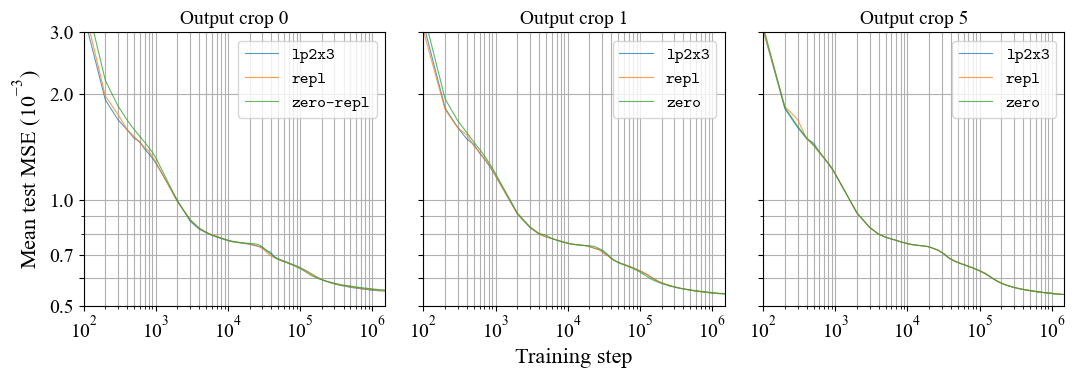

In [6]:
def create_history_plot(
    results,
    loss_ylims=(0.0005, 0.003),
):
    legend_fontsize_backup = plt.rcParams['legend.fontsize']
    plt.rc('legend', fontsize=MONOSPACE_SIZE)    # legend fontsize
    fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharex=True, sharey=True)
    for num_plot, (oc_value, oc_str) in enumerate(zip([0, 1, 5], ["", "_oc1", "_oc5"])):
        paddings = ["lp2x3", "repl", "zero" if oc_value > 0 else "zero-repl"]
        presets = [padding + oc_str for padding in paddings]
        seeds = get_common_success_seeds(presets)
        for preset, padding in zip(presets, paddings):
            slice = results["test_loss_histories"][preset][seeds]
            seed_mean_hist = np.nanmean(slice, axis=0)
            axs[num_plot].plot(get_test_loss_steps(hpars), seed_mean_hist, label=padding, linewidth=.8, alpha=0.75)
        axs[num_plot].set_title(f"Output crop {oc_value}")
        axs[num_plot].grid(axis="y", which="both")
        axs[num_plot].grid(axis="x", which="both")
        axs[num_plot].set_yscale("log")
        axs[num_plot].set_ylim(loss_ylims)
        axs[num_plot].set_xscale("log")
        axs[num_plot].legend()
        legend = axs[num_plot].legend()
        plt.setp(legend.get_texts(), font="cmtt10", size=MONOSPACE_SIZE)
        axs[num_plot].set_xlim(100, 1_500_000)
        
    #fig.legend(framealpha = 1)
    formatter = ScalarFormatter(useMathText=True, useOffset=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    axs[0].yaxis.set_major_formatter(formatter)  # Apply to the first subplot

    for i in range(3):
        axs[i].autoscale(enable=False, axis='y')
    
    fig.canvas.draw()
    y_offset = axs[0].yaxis.get_offset_text().get_text()
    if y_offset:  # If there is an offset
        axs[0].yaxis.offsetText.set_visible(False)  # Hide the original offset text
        if y_offset.startswith(r"$\times"):
            y_offset = "$" + y_offset[len(r"$\times"):]
        axs[0].set_ylabel(f"Mean test MSE ({y_offset})")
    else:
        axs[0].set_ylabel("Mean test MSE")
    ticks = np.array([5e-4, 6e-4, 7e-4, 1e-3, 2e-3, 3e-3])
    labels = np.astype(ticks*1e3, "str")
    labels[1] = ""

    axs[1].set_xlabel("Training step")
    axs[0].set_yticks(ticks, labels=labels)

    fig.tight_layout()
    fig.savefig(os.path.join(paths_config["graphs_folder"], "fig_test_loss_history.pdf"), pad_inches=0, bbox_inches="tight")
    plt.rc('legend', fontsize=legend_fontsize_backup)

create_history_plot(results)

# MSE scatterplot for presets and seeds

14 full, 3 el50, and 5 el1 models found


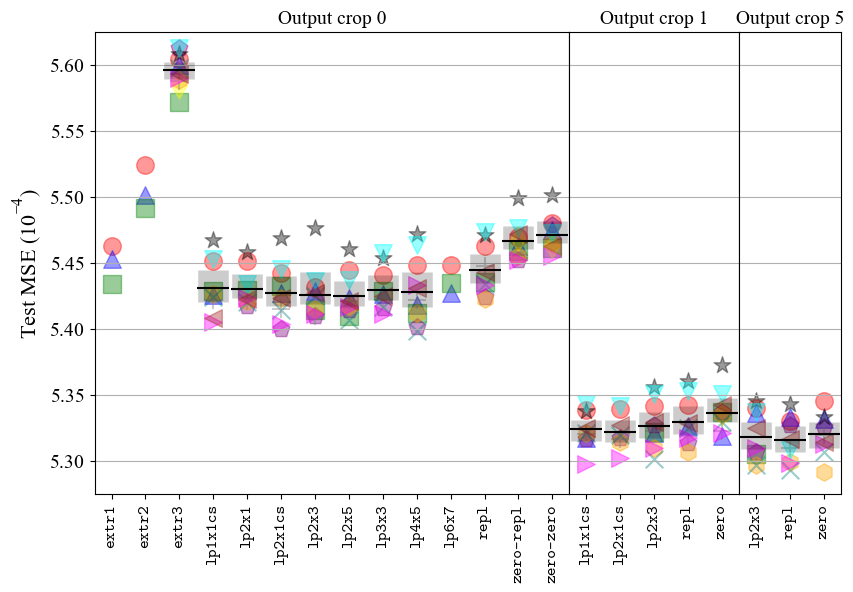

In [10]:
from scipy import stats
from matplotlib.ticker import MultipleLocator

def create_confidence_scatterplot(
    results,
    conf=0.95
):
    xtick_spacing = 1
    width, height = 11*0.875, 6

    mask_sums = get_mask_sums(hpars)
    shape_map = get_shape_list()
    cmap = get_color_list()
    full, el5, el1 = 0, 0, 0
    for preset in presets:
        if get_preset_hpars(preset)["model_hpars"]["output_crop"] == 5:
            el5 += 1
        elif get_preset_hpars(preset)["model_hpars"]["output_crop"] == 1:
            el1 += 1
        elif get_preset_hpars(preset)["model_hpars"]["output_crop"] == 0:
            full += 1
    print(f"{full} full, {el5} el50, and {el1} el1 models found")
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(width, height), gridspec_kw={'width_ratios': [full, el1, el5]})

    def plot_loss_group(num_plot, loss_type):
        x_step = 0
        names = []
        loss_means = []
        low_ci, high_ci = [], []
        for preset in sorted(presets):
            if loss_type == "full":
                edge_dist = 0
                el_cond = get_preset_hpars(preset)["model_hpars"]["output_crop"] == 0
            elif loss_type == "el5":
                edge_dist = 5
                el_cond = get_preset_hpars(preset)["model_hpars"]["output_crop"] == 5
            elif loss_type == "el1":
                edge_dist = 1
                el_cond = get_preset_hpars(preset)["model_hpars"]["output_crop"] == 1
            else:
                raise Exception(f"Unknown loss_type {loss_type}")
            if not el_cond:
                continue

            incl_seeds = get_common_success_seeds([preset])
            loss_list = []
            for seed in incl_seeds:
                loss = results["output_crop_sumsqs"][preset][seed][edge_dist] / mask_sums[edge_dist]
                loss_list.append(loss)
            loss_arr = np.vstack(loss_list)
            preset_best = np.mean(loss_arr, axis=1) # (seeds,)
            preset_name = preset.split("_")[0]
            if preset_name == "zero" and loss_type == "full":
                preset_name = "zero-repl"
            elif preset_name == "zerozero":
                preset_name = "zero-zero"
            names.append(preset_name)
            if len(incl_seeds) < 4: # no means and confidence intervals for sample size 3 or lower
                low_ci.append(np.nan)
                high_ci.append(np.nan)
                loss_means.append(np.nan)
            else: # means and confidence intervals
                loss_mean = np.mean(preset_best) # mean across seeds -> (1,)
                result = stats.bootstrap((preset_best,), np.nanmean, vectorized=True, confidence_level=conf)
                low_ci.append(loss_mean - result.confidence_interval.low)
                high_ci.append(result.confidence_interval.high - loss_mean)
                loss_means.append(loss_mean)
            # scatter plot
            shapes = [shape_map[seed] for seed in incl_seeds] # match each seed with unique shape and color
            colors = [cmap[seed] for seed in incl_seeds]
            for n in range(len(incl_seeds)): # shapes cannot be given a list and have to be looped across
                ax[num_plot].scatter(x_step, preset_best[n], marker=shapes[n], c=colors[n], s=160.0, alpha=0.4)
            x_step += 1
        # plotting confidence intervals
        err = [low_ci, high_ci]
        x = np.arange(len(names))
        ax[num_plot].errorbar(x, loss_means, yerr=err, linestyle='',
                    capthick=2, #label=f"{conf*100} % confidence",
                    color="black", elinewidth=22, alpha=0.2)
        ax[num_plot].scatter(x, loss_means, marker="_", label="mean", s=500, color="black")
        ax[num_plot].set_xticks(x, labels=names, rotation=90, font="cmtt10", size=12)
        ax[num_plot].grid(axis="y")
        ax[num_plot].xaxis.set_major_locator(MultipleLocator(xtick_spacing))
        loss_type_dict = {"full": 0, "el5": 5, "el1": 1}
        ax[num_plot].set_title(f'Output crop {loss_type_dict[loss_type]}')
        if num_plot != 0:
            ax[num_plot].tick_params(left=False, labelleft=False)
        ax[num_plot].set_ylim(5.275e-4, 5.625e-4)

    plot_loss_group(0, "full")
    plot_loss_group(1, "el1")
    plot_loss_group(2, "el5")

    if True:        
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        ax[0].yaxis.set_major_formatter(formatter)  # Apply to the first subplot

    #ax[0].spines["right"].set_visible(False)
    #ax[1].spines["left"].set_visible(False)
    #yaxis = ax[0].yaxis
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #yaxis.set_ticklabels([float(label.get_text()) * (100//yaxis_mult) / 100 for label in yaxis.get_ticklabels()])

    ax[0].set_xlim(-0.5, full-0.5)
    ax[1].set_xlim(-0.5, el1-0.5)
    ax[2].set_xlim(-0.5, el5-0.5)

    #plt.draw() # Instantiates the offset text so it can be extracted
    fig.canvas.draw()
    y_offset = ax[0].yaxis.get_offset_text().get_text()
    if y_offset:  # If there is an offset
        ax[0].yaxis.offsetText.set_visible(False)  # Hide the original offset text
        if y_offset.startswith(r"$\times"):
            y_offset = "$" + y_offset[len(r"$\times"):]
        ax[0].set_ylabel(f"Test MSE ({y_offset})")
    else:
        ax[0].set_ylabel("Test MSE")

    #fig.supxlabel("padding method", y=-0.55/height)
    plt.subplots_adjust(wspace=0)
    plt.savefig(os.path.join(paths_config["graphs_folder"], "fig_scatterplot_presets_seeds.pdf"), pad_inches=0, bbox_inches="tight")
    plt.show()


create_confidence_scatterplot(results)

# Throughput chart

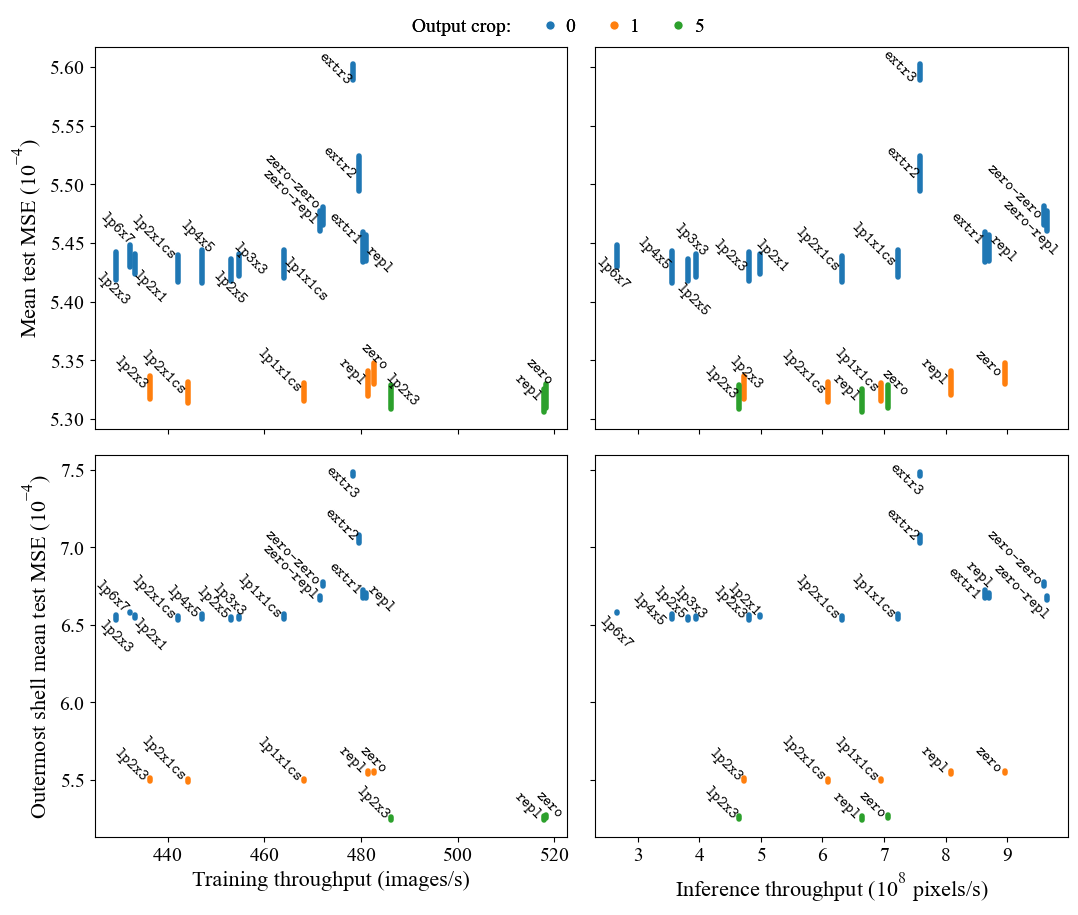

In [11]:
def throughput_scatterplot():
    label_offsets_outermost = {
        "train": {
            "lp1x1cs": (0, 0),
            "lp1x1cs_oc1": (0, 0),
            "lp2x1": (34, -22),
            "lp2x1cs": (0, 0),
            "lp2x1cs_oc1": (0, 0),
            "lp2x3": (19, -22),
            "lp2x3_oc1": (0, 0),
            "lp2x3_oc5": (0, 0),
            "lp2x5": (0, 0),
            "lp3x3": (8, 2),
            "lp4x5": (0, 0),
            "lp6x7": (0, 0),
            "zero-repl": (0, 0),
            "zero_oc1": (15, 0),
            "zero_oc5": (20, 0),
            "zero-zero": (0, 0),
            "repl": (32, -10),
            "repl_oc1": (0, 0),
            "repl_oc5": (0, 0),
            "extr1": (0, 0),
            "extr2": (0, 0),
            "extr3": (8, -15),
        },
        "inference": {
            "lp1x1cs": (0, 0),
            "lp1x1cs_oc1": (0, 0),
            "lp2x1": (4, 1),
            "lp2x1cs": (0, 0),
            "lp2x1cs_oc1": (0, 0),
            "lp2x3": (0, 0),
            "lp2x3_oc1": (0, 0),
            "lp2x3_oc5": (0, 0),
            "lp2x5": (0, 0),
            "lp3x3": (20, 0),
            "lp4x5": (-8, -5),
            "lp6x7": (29, -23),
            "zero-repl": (8, -13),
            "zero_oc1": (0, 0),
            "zero_oc5": (0, 0),
            "zero-zero": (0, 0),
            "repl": (11, 5),
            "repl_oc1": (0, 0),
            "repl_oc5": (0, 0),
            "extr1": (-5, -3),
            "extr2": (0, 0),
            "extr3": (8, -13),
        }
    }
    label_offsets_full = {
        "train": {
            "lp1x1cs": (24, -15),
            "lp1x1cs_oc1": (0, 0),
            "lp2x1": (17, -15),
            "lp2x1cs": (0, 5),
            "lp2x1cs_oc1": (0, 0),
            "lp2x3": (8, -14),
            "lp2x3_oc1": (0, 0),
            "lp2x3_oc5": (15, -3),
            "lp2x5": (9, -13),
            "lp3x3": (15, -3),
            "lp4x5": (7, 7),
            "lp6x7": (3, 6),
            "zero-repl": (0, 0),
            "zero_oc1": (8, 3),
            "zero_oc5": (5, 5),
            "zero-zero": (0, 4),
            "repl": (15, -10),
            "repl_oc1": (0, 0),
            "repl_oc5": (0, 0),
            "extr1": (0, 0),
            "extr2": (-1, 0),
            "extr3": (0, -5),
        },
        "inference": {
            "lp1x1cs": (0, 0),
            "lp1x1cs_oc1": (0, 0),
            "lp2x1": (25, -2),
            "lp2x1cs": (0, 0),
            "lp2x1cs_oc1": (0, 0),
            "lp2x3": (0, 0),
            "lp2x3_oc1": (16, 0),
            "lp2x3_oc5": (0, 0),
            "lp2x5": (19, -18),
            "lp3x3": (11, 5),
            "lp4x5": (0, 0),
            "lp6x7": (12, -13),
            "zero-repl": (11, -13),
            "zero_oc1": (0, 0),
            "zero_oc5": (19, 0),
            "zero-zero": (0, 0),
            "repl": (25, -5),
            "repl_oc1": (0, 0),
            "repl_oc5": (0, 0),
            "extr1": (0, 0),
            "extr2": (0, 0),
            "extr3": (-2, -4),
        }
    }

    fig, axs = plt.subplots(2, 2, figsize=(11, 9), sharey="row", sharex="col")
    mask_sums = get_mask_sums(hpars)
    colors = list(mcolors.TABLEAU_COLORS.values())
    for row, shell_mode in zip([0, 1], ["full", "outermost"]):
        for col, mode in zip([0, 1], ["train", "inference"]):
            for preset in preset_ids:
                lc_value = get_preset_hpars(preset)["model_hpars"]["output_crop"]
                time_s_per_batch = np.mean(results[f"{mode}_step_times"][preset][1:])
                batch_size = results[f"largest_{mode}_batch_sizes"][preset]
                time_s_per_image = time_s_per_batch/batch_size
                #time_s_per_image += 0.00001492114  # PCIe 4.0 memory transfer
                time_s_per_pixel = time_s_per_image/mask_sums[lc_value]
                throughput_images_per_s = 1/time_s_per_image
                throughput_pixels_per_s = 1/time_s_per_pixel
                padding = preset.split("_")[0]
                seed_losses = []
                if shell_mode == "outermost":
                    label_offset_x, label_offset_y = label_offsets_outermost[mode][preset]
                    for sse_table_for_seed in results["output_crop_sumsqs"][preset].values():
                        seed_losses.append(
                            np.mean(sse_table_for_seed[lc_value] - sse_table_for_seed[lc_value + 1])/(mask_sums[lc_value] - mask_sums[lc_value + 1])
                        )
                elif shell_mode == "full":
                    label_offset_x, label_offset_y = label_offsets_full[mode][preset]
                    label_offset_y *= 0.2
                    label_offset_x *= 2
                    for sse_table_for_seed in results["output_crop_sumsqs"][preset].values():
                        seed_losses.append(
                            np.mean(sse_table_for_seed[lc_value])/(mask_sums[lc_value])
                        )
                result = stats.bootstrap(
                    (np.array(seed_losses),), np.mean, confidence_level=0.95, n_resamples=10_000
                )
                ci_low, ci_high = result.confidence_interval
                loss = np.mean(seed_losses)
                if mode == "train":
                    x_val = throughput_images_per_s
                else:
                    x_val = throughput_pixels_per_s
                label_offset_mult = 1e6 if mode == "inference" else 0.2
                axs[row, col].text(x_val + label_offset_x*label_offset_mult, loss + label_offset_y*1e-6, padding, horizontalalignment='right', rotation=-45, font="cmtt10", size=11)
                lc_order = 2 if lc_value == 5 else lc_value
                _, _, bars = axs[row, col].errorbar(
                    x_val,
                    loss,
                    yerr=((np.abs(ci_low-loss),), (np.abs(loss-ci_high),)), 
                    capsize=0,
                    elinewidth=4,
                    markersize=0,
                    color=colors[lc_order]
                )
                plt.setp(bars, capstyle="round")
            if row == 1:
                formatter = ScalarFormatter(useMathText=True)
                formatter.set_scientific(True)
                formatter.set_powerlimits((-3, 3))
                axs[row, col].xaxis.set_major_formatter(formatter)
                axs[row, col].ticklabel_format(axis='x', style='sci', scilimits=(-3,3))    
                fig.canvas.draw()
                x_offset = axs[row, col].xaxis.get_offset_text().get_text()
                if x_offset:
                    axs[row, col].xaxis.offsetText.set_visible(False)
                    if x_offset.startswith(r"$\times"):
                        x_offset = "$" + x_offset[len(r"$\times"):]
                    elif x_offset.startswith("1e"):
                        exponent = int(np.log10(float(x_offset)))
                        print(x_offset, exponent)
                        x_offset = r"$\times\mathdefault{10^{" + str(exponent) + r"}}\mathdefault{}$" #$\mathrm{\mu}$
                    label_str = (mode + "ing" if mode == "train" else mode) + r" throughput (" + x_offset + " " + ("images" if mode == "train" else "pixels") + "/s)"
                else:
                    label_str = (mode + "ing" if mode == "train" else mode) + r" throughput (" + ("images" if mode == "train" else "pixels") + "/s)"
                label_str = label_str[0].upper() + label_str[1:] # capitalize
                axs[row, col].set_xlabel(label_str)

        y_axis_str = "Outermost shell mean test MSE" if shell_mode == "outermost" else "Mean test MSE"
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 3))
        axs[row, 0].yaxis.set_major_formatter(formatter)
        axs[row, 0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))    
        fig.canvas.draw()
        y_offset = axs[row, 0].yaxis.get_offset_text().get_text()
        if y_offset:
            axs[row, 0].yaxis.offsetText.set_visible(False)
            if y_offset.startswith(r"$\times"):
                y_offset = "$" + y_offset[len(r"$\times"):]
            axs[row, 0].set_ylabel(f"{y_axis_str} ({y_offset})")
        else:
            axs[row, 0].set_ylabel(f"{y_axis_str}")
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color="w", label='Output crop:', markerfacecolor="w", markersize=7),
            plt.Line2D([0], [0], marker='o', color="w", label='0', markerfacecolor=colors[0], markersize=7),
            plt.Line2D([0], [0], marker='o', color="w", label='1', markerfacecolor=colors[1], markersize=7),
            plt.Line2D([0], [0], marker='o', color="w", label='5', markerfacecolor=colors[2], markersize=7)
        ]
        legend = fig.legend(handles=legend_elements, loc="lower center",
                   ncol=4, bbox_to_anchor=(0.51, 0.97), handlelength=0, frameon=False)
        fig.tight_layout()
        fig.savefig(os.path.join(paths_config["graphs_folder"], "fig_time.pdf"), pad_inches=0, bbox_inches="tight")

throughput_scatterplot()

# Output crop bar graph

valid seeds: [ 0  2  4  5  6  9 10 11]
valid seeds: [ 1  4  5  6  7  8  9 10 11]
valid seeds: [ 0  1  4  5  6  7  8 10 11]


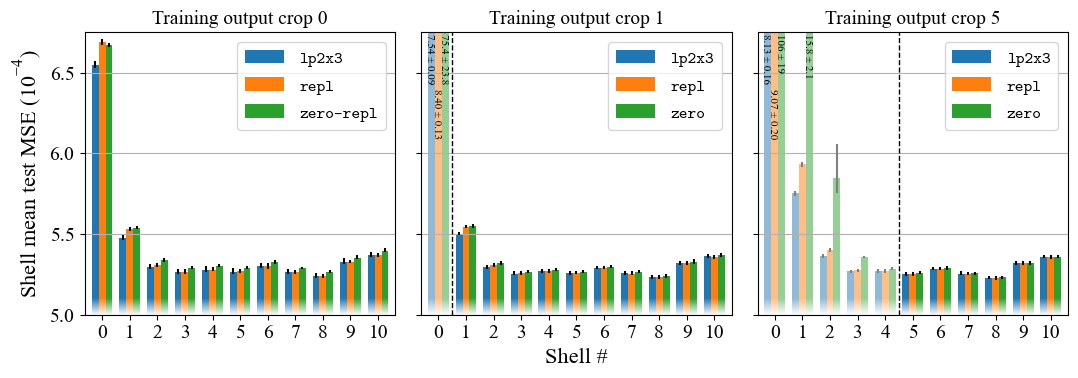

In [31]:
def composite_loss_crop_scatterplot(
        results,
        conf = 0.95,
        resamples = 10_000,
        xmin = -0.625,
        xmax = 10.625,
        fixed_mult = 10**-4,
    ):

    # utility functions
    def format_confidence_interval(value, ci):
        if value/fixed_mult > 100:
            decimal_formatted_value = f"{value/fixed_mult:.0f} ± {ci/fixed_mult:.0f}"
        elif value/fixed_mult > 10:
            decimal_formatted_value = f"{value/fixed_mult:.1f} ± {ci/fixed_mult:.1f}"
        else:
            decimal_formatted_value = f"{value/fixed_mult:.2f} ± {ci/fixed_mult:.2f}"
        return decimal_formatted_value

    def plot_group(means_of_means, ci_low, ci_high, preset, n, col, train_edge, ymax):
        x_offset = [-0.25, 0, 0.25][n]
        ranges = [np.arange(train_edge, dtype=np.int32), np.arange(train_edge, 11, dtype=np.int32)]
        for range_object, alpha, use_label, errcolor in zip(ranges, [0.5, 1], [False, True], ["gray", "black"]):
            padding = preset.split("_")[0]
            cond = padding == "zero" and col == 0
            label_str = "zero-repl" if cond else padding
            axs[col].bar(range_object+x_offset, np.array(means_of_means)[range_object],
                        label=label_str if use_label else None, color=list(mcolors.TABLEAU_COLORS.keys())[n],
                        width=0.25, alpha=alpha
            )
            axs[col].errorbar(range_object+x_offset, np.array(means_of_means)[range_object],
                        yerr=(np.array(ci_low)[range_object], np.array(ci_high)[range_object]), 
                        linestyle='', color=errcolor
            )
        for y, x, ci in zip(means_of_means, np.arange(11)+x_offset, np.maximum(ci_low, ci_high)):
            if y > ymax:
                height = ymax-3.5e-5 if n==1 else ymax-1e-6
                axs[col].text(x-0.05, height, format_confidence_interval(y, ci),
                                   size=8, rotation=270, verticalalignment="top",
                                   horizontalalignment="center"
                )

    master_preset_list = [
        ["lp2x3", "repl", "zero-repl"],
        ["lp2x3_oc1", "repl_oc1", "zero_oc1"],
        ["lp2x3_oc5", "repl_oc5", "zero_oc5"]
    ]

    # plot values
    fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharex=True, sharey=False)
    ymin, ymax = 5e-4, 6.75e-4 # tighter #ymin, ymax = 4e-4, 1.5e-2 # shows everything
    for col, (preset_list, cutoff) in enumerate(zip(master_preset_list, [0,1,5])):
        valid_seeds = get_common_success_seeds(preset_list)
        print(f"valid seeds: {valid_seeds}")
        for n, preset in enumerate(preset_list):
            means_of_means, ci_low, ci_high, _ = get_1d_onion_bootstrap_abs(
                results, preset, valid_seeds, conf, resamples
            )
            plot_group(means_of_means, ci_low, ci_high, preset, n, col, cutoff, ymax)
        axs[col].set_xticks(np.arange(11))
        if cutoff != 0:
            axs[col].vlines([cutoff-0.5,], ymin, ymax, color="black",
                                    linestyles="dashed", linewidth=1.0, zorder=100)
        axs[col].set_ylim(ymin, ymax)
        axs[col].set_xlim(xmin, xmax)
        axs[col].grid(axis="y", which="major")
        axs[col].legend(loc="upper right")
        legend = axs[col].legend()
        plt.setp(legend.get_texts(), font="cmtt10", size=MONOSPACE_SIZE)
        if col == 0:
            axs[col].set_ylabel(f"mean test MSE difference with zero-pad")
        if col != 0:
            axs[col].set_yticklabels([])
        axs[col].set_title(f"Training output crop {cutoff}")

        # fade out at bottom
        x = np.linspace(0, 1, 100)
        y = np.linspace(0, 1, 100)
        X, Y = np.meshgrid(x, y)
        colors = [(1, 1, 1, 0), (1, 1, 1, 1)]
        cmap = mcolors.LinearSegmentedColormap.from_list('white_to_transparent', colors)
        axs[col].imshow(
            Y, cmap=cmap, extent=[xmin, xmax, ymin, ymin + 0.06*(ymax-ymin)], aspect="auto", zorder=1
        )
    axs[1].set_xlabel("Shell #")

    # moving the multiplier from the axis to the axis label
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    axs[0].yaxis.set_major_formatter(formatter) # Apply to the first subplot
    fig.canvas.draw()
    y_offset = axs[0].yaxis.get_offset_text().get_text()
    if y_offset: # If there is an offset
        axs[0].yaxis.offsetText.set_visible(False) # Hide the original offset text
        if y_offset.startswith(r"$\times"):
            y_offset = "$" + y_offset[len(r"$\times"):]
        axs[0].set_ylabel(f"Shell mean test MSE ({y_offset})")
    else:
        axs[0].set_ylabel("Shell mean test MSE")
    fig.tight_layout()
    fig.savefig(os.path.join(paths_config["graphs_folder"], "fig_loss_shells.pdf"), pad_inches=0, bbox_inches="tight")

composite_loss_crop_scatterplot(results)

## Numerical data of the output crop bar graph

In [ ]:
def composite_loss_crop_table(
        results,
        conf = 0.95,
        resamples = 10_000,
        restricted_seeds = False, # restrict all plots to have the same set of seeds
    ):

    # the data from shell mean MSE bar graph but in table form, for more detailed inspection

    master_preset_list = [
        ["lp2x3", "repl", "zero-repl"],
        ["lp2x3_oc1", "repl_oc1", "zero_oc1"],
        ["lp2x3_oc5", "repl_oc5", "zero_oc5"]
    ]
    if restricted_seeds:
        valid_seeds = get_common_success_seeds(master_preset_list[0]+master_preset_list[1]+master_preset_list[2])
        print(f"valid seeds: {valid_seeds}")
    index_col_1 = [0]*3 + [1]*3 + [5]*3
    index_col_2 = master_preset_list[0]+master_preset_list[1]+master_preset_list[2]
    df = pd.DataFrame(columns = pd.MultiIndex.from_arrays([index_col_1, index_col_2], names=["Output crop", "Preset"]))                

    for preset_list, oc_value in zip(master_preset_list, [0,1,5]):
        if not restricted_seeds:
            valid_seeds = get_common_success_seeds(preset_list)
        for preset in preset_list:
            means_of_means, ci_low_list, ci_high_list, _ = get_1d_onion_bootstrap_abs(
                results, preset, valid_seeds, conf, resamples
            )
            for shell_num, (mean, ci_low, ci_high) in enumerate(zip(means_of_means, ci_low_list, ci_high_list)):
                err = np.maximum(ci_high, ci_low)
                err_str = str(err*1e6)[:3]
                if err_str.endswith("."):
                    err_str = err_str[:2]
                val_str = str(mean*1e6)[:5]
                if val_str.endswith("."):
                    val_str = val_str[:4]
                df.loc[shell_num, (oc_value, preset)] = val_str + "±" + err_str
    return df

composite_loss_crop_table(results)

Output crop          0                                1                        \
Preset           lp2x3       repl  zero-repl  lp2x3_oc1   repl_oc1   zero_oc1   
0            654.5±2.6  668.9±2.0  667.0±1.4  753.7±8.3   840.1±12   7541±239   
1            547.4±1.9  553.0±1.3  553.9±1.0  550.1±1.1  554.4±1.2  554.8±1.2   
2            529.5±2.0  530.8±1.2  533.8±1.5  529.5±1.3  530.5±1.3  531.8±1.5   
3            526.2±1.9  526.5±1.4  529.0±1.4  525.5±1.2  525.6±1.2  526.6±1.2   
4            527.9±2.0  527.9±1.5  530.2±1.2  527.0±1.3  527.0±1.3  527.8±1.3   
5            526.6±2.1  526.8±1.6  529.2±1.2  525.9±1.2  525.7±1.2  526.5±1.3   
6            529.9±1.8  530.0±1.7  532.4±1.3  529.1±1.1  529.0±1.2  529.8±1.0   
7            526.4±1.9  526.4±1.1  528.8±0.8  525.6±1.2  525.4±1.3  526.4±1.1   
8            523.7±1.9  523.9±1.1  526.3±1.2  523.1±1.2  523.1±1.6  523.8±1.2   
9            532.8±2.4  532.9±1.1  535.4±1.4  532.2±1.3  531.8±1.5  532.7±1.6   
10           536.7±2.1  536.8±1.4  539.6±1.4  536.1±1.3  535.7±1.4  536.7±1.4   

Output crop          5                        
Preset       lp2x3_oc5   repl_oc5   zero_oc5  
0             813.2±14   907.3±20  10572±195  
1            575.5±1.8  593.3±1.6   1579±198  
2            536.3±1.2  539.9±1.4   584.9±20  
3            526.8±1.0  527.5±1.0  535.9±0.8  
4            526.9±1.0  526.8±1.1  528.6±1.1  
5            525.3±1.1  525.4±1.2  526.1±1.0  
6            528.5±1.2  528.6±0.9  528.8±1.0  
7            525.4±1.3  525.4±1.0  525.7±0.9  
8            522.8±1.2  522.7±1.0  523.2±0.9  
9            532.0±1.3  531.8±1.2  532.1±1.1  
10           535.9±1.2  535.7±1.1  536.0±1.0

# General data table

In [41]:
def save_table(
    results,
    baseline_list = ["zero-repl", "zero_oc1", "zero_oc5"]
):

    # helper functions
    def get_error(arr):
        assert len(arr.shape) == 1, f"{arr.shape}"
        result = stats.bootstrap((arr,), np.nanmean, vectorized=True)
        low, high = result.confidence_interval
        error = np.maximum(high-arr, arr-low) # symmetric, worst-case estimate
        return error

    def get_train_throughput(preset):
        batch_size = results["largest_train_batch_sizes"][preset]
        time_list = np.array(results["train_step_times"][preset])
        time_per_batch = np.mean(time_list[1:])
        return batch_size / time_per_batch
    
    def get_inference_throughput(preset):
        batch_size = results["largest_inference_batch_sizes"][preset]
        time_list = np.array(results["inference_step_times"][preset])
        time_per_batch = np.mean(time_list[1:])
        lc_value = get_preset_hpars(preset)["model_hpars"]["output_crop"]
        pixels_per_img = mask_sums[lc_value]
        return batch_size * pixels_per_img / time_per_batch

    def outermost_shell_diff(preset, baseline, lc_value, conf=0.95, resamples=10_000):
        def get_onion_loss(preset, baseline, seed, edge_dist):
            assert edge_dist < 10
            mask_sums = get_mask_sums(hpars)
            corr_fact = mask_sums[edge_dist]-mask_sums[edge_dist+1]
            loss = np.mean(results["output_crop_sumsqs"][preset][seed][edge_dist]
                    - results["output_crop_sumsqs"][preset][seed][edge_dist+1]) / corr_fact
            baseline_loss = np.mean(results["output_crop_sumsqs"][baseline][seed][edge_dist]
                    - results["output_crop_sumsqs"][baseline][seed][edge_dist+1]) / corr_fact
            return (loss - baseline_loss)/baseline_loss*100
        lc_value = int(lc_value)
        valid_seeds = get_common_success_seeds((preset, baseline))
        loss_means = []
        for seed in valid_seeds:
            loss_means.append(np.mean(get_onion_loss(preset, baseline, seed, lc_value)))
        if preset != baseline:
            result = stats.bootstrap(
                (np.array(loss_means),), np.mean, confidence_level=conf, n_resamples=resamples
            )
            low, high = result.confidence_interval
            low_val = np.abs(np.mean(loss_means) - low)
            high_val = np.abs(high - np.mean(loss_means))
            ci = np.maximum(low_val, high_val)
        else:
            ci = ""
        return str(np.mean(loss_means))  + r" \pm " + str(ci)

    mask_sums = get_mask_sums(hpars)
    loss_mult = 1e-6
    througput_mult = 1e6
    valid_presets = {0: [], 1: [], 5: []} # lists contain (preset, row_name) tuples
    for preset in presets.keys():
        row_name, loss_crop = (r"\texttt{" + preset.split("_")[0] + "}", get_preset_hpars(preset)["model_hpars"]["output_crop"])
        valid_presets[loss_crop].append((preset, row_name))

    # setting up dataframe
    index_col_1 = []
    for output_crop, group_presets_list in valid_presets.items():
        count = len(group_presets_list)
        index_col_1 += [output_crop]*count
    index_col_2 = []
    for l in valid_presets.values():
        for _, pad in sorted(l):
            index_col_2.append(pad)
    data = pd.DataFrame(index = pd.MultiIndex.from_arrays([index_col_1, index_col_2], names=["Output crop", "Preset"]))

    # populate values
    for (lc_value, preset_pad_list), baseline in zip(valid_presets.items(), baseline_list):
        for preset, row_name in preset_pad_list:
            incl_seeds = get_common_success_seeds([baseline, preset])
            p_list, b_list = [], []
            for seed in incl_seeds:
                p_loss = results["output_crop_sumsqs"][preset][seed][lc_value] / mask_sums[lc_value]
                b_loss = results["output_crop_sumsqs"][baseline][seed][lc_value] / mask_sums[lc_value]
                p_list.append(np.mean(p_loss))
                b_list.append(np.mean(b_loss))
            preset_losses = np.hstack(p_list)
            baseline_losses = np.hstack(b_list)
            diff = preset_losses - baseline_losses
            diff_percent = diff/baseline_losses*100 # shape is (seed,)
            data.loc[(lc_value, row_name), "Maximum training batch size (images)"] = results["largest_train_batch_sizes"][preset]
            data.loc[(lc_value, row_name), "Training throughput (images/s)"] = get_train_throughput(preset)
            data.loc[(lc_value, row_name), "Maximum inference batch size (images)"] = results["largest_inference_batch_sizes"][preset]
            inf_throughput_colname = r"{Inference throughput ($10^{" + str(int(np.log10(througput_mult))) + r"}$ pixels/s)}"
            data.loc[(lc_value, row_name), inf_throughput_colname] = get_inference_throughput(preset) / througput_mult
            if preset != baseline:
                diff_err_str = np.mean(get_error(diff_percent)).astype(str)
                loss_err_str = (np.mean(get_error(preset_losses))/loss_mult).astype(str)
            else:
                diff_err_str, loss_err_str = "", ""
            loss_str = (np.mean(preset_losses)/loss_mult).astype(str)
            data.loc[(lc_value, row_name), r"{Mean test MSE ($10^{" + str(int(np.log10(loss_mult))) + r"}$)}"] = loss_str + r" \pm " + loss_err_str
            diff_str = "0.00" if preset == baseline else np.mean(diff_percent).astype(str)
            data.loc[(lc_value, row_name), "Mean test MSE diff to " + baseline_list[0] + r" (\%)"] = diff_str + r" \pm " + diff_err_str
            outermost_colname = "Outermost shell mean test MSE diff to " + baseline_list[0] + r" (\%)"
            data.loc[(lc_value, row_name), outermost_colname] = outermost_shell_diff(preset, baseline, int(lc_value))

    # replace invalid values
    data[data == r"0.00 \pm "] = "0.00"
    data[data == r"0.0 \pm "] = "0.00"

    # rename and format columns
    def process_column_name(s):
        return r"{\rotatebox[origin=l]{90}{\parbox{3.0cm}{\raggedright " + s + r"}}}"
    new_names = {}
    for col in data.columns:
        new_names[col] = process_column_name(col)
    data = data.rename(columns=new_names)
    data = data.astype(str)
    
    # make best values bold
    for oc_value in [0, 1, 5]:
        temp = data.loc[oc_value]
        for col in temp.columns:
            if temp[col].str.contains(" ").any(): # if there are spaces, indicating "val \pm err" format
                stripped_series = temp[col].str.split(" ").str[0]
                target_idx = stripped_series.astype(float).idxmin()
                target_val = temp.loc[target_idx, col]
                data.loc[(oc_value, target_idx), col] = r"\bfseries " + str(target_val)
            else: # no spaces, indicating int or float only, may be multiple best
                target_val = temp[col].max()
                target_idx_list = temp[col][temp[col] == target_val].index.tolist()
                for idx in target_idx_list:
                    data.loc[(oc_value, idx), col] = r"\bfseries " + str(target_val)

    # format latex table
    def int_col(width):
        return f"S[round-mode=places,round-precision=0,table-column-width={width}cm]" # throughput and time columns
    latex_str = data.to_latex(
        column_format=(
            r"p{0.17cm}p{1.4cm}"
            + int_col(0.6)*4
            + "S[table-format=3.1(2)]S[table-format=3.2(2)]"            
            + "S[table-format=3.2(1)]"
        ),
        multirow=True
    )
    return data, latex_str

data, table_str = save_table(results)

display(data)

{\rotatebox[origin=l]{90}{\parbox{3.0cm}{\raggedright Maximum training batch size (images)}}}  \
Output crop Preset                                                                                                             
0           \texttt{extr1}                                        \bfseries 266.0                                              
            \texttt{extr2}                                        \bfseries 266.0                                              
            \texttt{extr3}                                        \bfseries 266.0                                              
            \texttt{lp1x1cs}                                                237.0                                              
            \texttt{lp2x1}                                                  190.0                                              
            \texttt{lp2x1cs}                                                189.0                                              
            \texttt{lp2x3}                                                  187.0                                              
            \texttt{lp2x5}                                                  240.0                                              
            \texttt{lp3x3}                                                  241.0                                              
            \texttt{lp4x5}                                                  236.0                                              
            \texttt{lp6x7}                                                  191.0                                              
            \texttt{repl}                                         \bfseries 266.0                                              
            \texttt{zero-repl}                                              263.0                                              
            \texttt{zero-zero}                                              263.0                                              
1           \texttt{lp1x1cs}                                                238.0                                              
            \texttt{lp2x1cs}                                                191.0                                              
            \texttt{lp2x3}                                                  188.0                                              
            \texttt{repl}                                         \bfseries 268.0                                              
            \texttt{zero}                                         \bfseries 268.0                                              
5           \texttt{lp2x3}                                                  257.0                                              
            \texttt{repl}                                         \bfseries 325.0                                              
            \texttt{zero}                                         \bfseries 325.0                                              

                               {\rotatebox[origin=l]{90}{\parbox{3.0cm}{\raggedright Training throughput (images/s)}}}  \
Output crop Preset                                                                                                       
0           \texttt{extr1}                                     480.45210106668037                                        
            \texttt{extr2}                                      479.6539065533484                                        
            \texttt{extr3}                                     478.39504981972766                                        
            \texttt{lp1x1cs}                                    463.9951739869162                                        
            \texttt{lp2x1}                                     433.30257223306324                                        
            \texttt{lp2x1cs}                                   442.15472796367374                       